# Продвинутая визуализация данных. Домашнее задание 5 (vo_HW)

Обзор данных
Содержание. Этот набор данных содержит информацию о трех разных типах вина и ряд их характеристик.

Всего в датасете 13 характеристик: Alcohol, Malic, Ash, Alcalinity, Magnesium, Phenols, Flavanoids, Nonflavanoids, Proanthocyanins, Color, Hue, Dilution, Proline.

Мы будем работать с этим датасетом, используя алгоритмы понижения размерности и машинного обучения.

In [1]:
# %%capture
# !pip install catboost
# !pip install lightgbm
# !pip install xgboost
# !pip install opentsne
# !pip install umap-learn

In [2]:
# Data manipulation
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

# Data preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import label_binarize

# Dimensionality Reduction
from openTSNE.sklearn import TSNE
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from umap import UMAP

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_05_visualization/wine.csv')
df.head(3)

,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


(178, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             178 non-null    int64  
 1   Alcohol          178 non-null    float64
 2   Malic            178 non-null    float64
 3   Ash              178 non-null    float64
 4   Alcalinity       178 non-null    float64
 5   Magnesium        178 non-null    int64  
 6   Phenols          178 non-null    float64
 7   Flavanoids       178 non-null    float64
 8   Nonflavanoids    178 non-null    float64
 9   Proanthocyanins  178 non-null    float64
 10  Color            178 non-null    float64
 11  Hue              178 non-null    float64
 12  Dilution         178 non-null    float64
 13  Proline          178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB
None


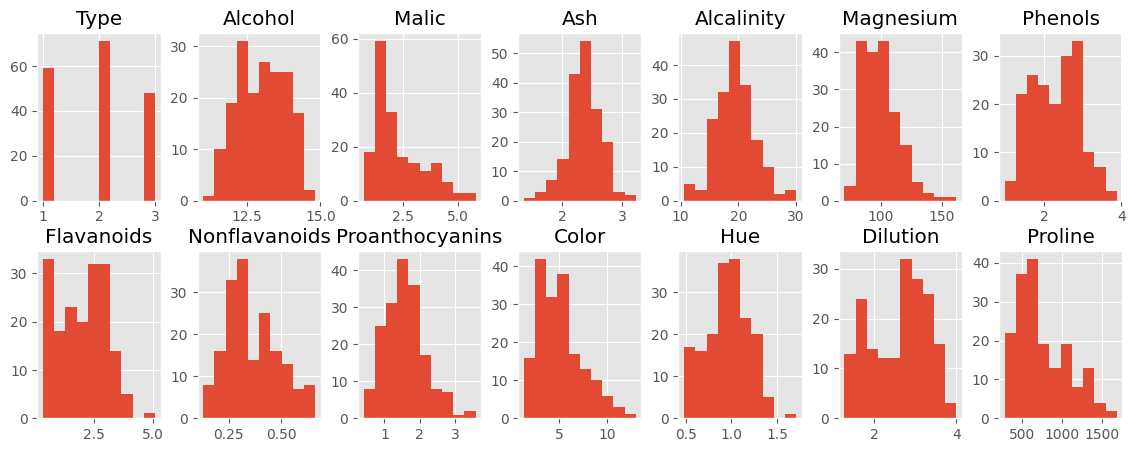

In [4]:
print(df.shape)
print(df.info())
df.hist(figsize=(14, 5), layout=(2, 7));

## Задание 1. Разведочный анализ данных (2 балла)
Воспользуйтесь графиком sns.displot() и постройте 13 графиков распределения разных переменных на одном поле subplots. Параметр hue возьмите равным Type.

Напишите, какие выводы о различиях в типах вин можно сделать исходя из этих графиков.

In [5]:
df.columns

Index(['Type', 'Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Magnesium', 'Phenols',
       'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Color', 'Hue',
       'Dilution', 'Proline'],
      dtype='object')

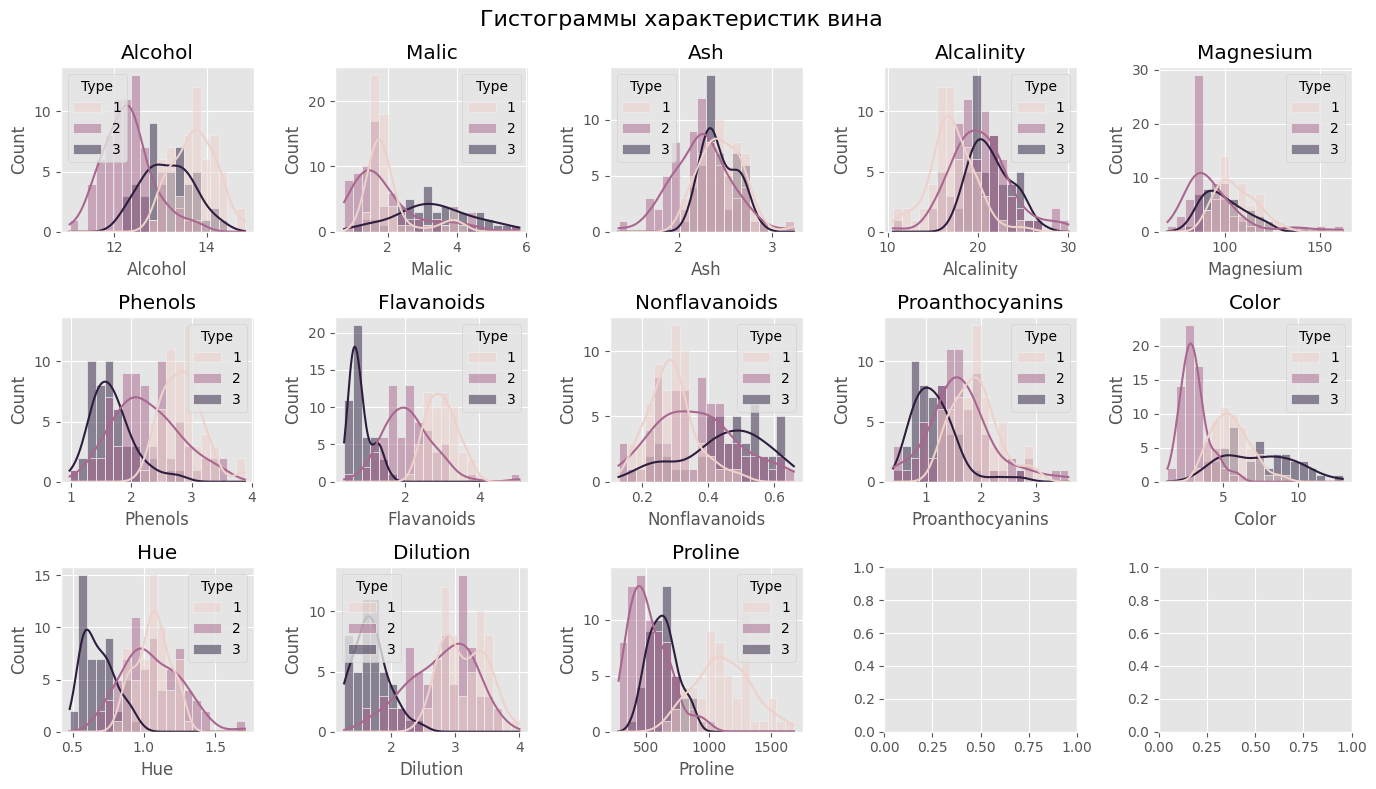

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(14, 8))
fig.suptitle('Гистограммы характеристик вина', fontsize=16)
axes = axes.flatten()

for i, column in enumerate(df.iloc[:, 1:].columns):
    sns.histplot(df[1:], x=column, bins=20, hue='Type', kde=True, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

*Характеристики типов вин:*
* *1 тип: крепкие, средней кислотности, высокозольные, но с низкой щелочностью золы, с высоким содержанием магния, фенолов, флавонидов, проантоцианидинов и пролина. Цвет и отенок насыщенный.*
* *2 тип: слабоалкогольные, светлые, оттекнок средней насыщенности. Низкий уровень кислотности, магния и пролина, остальные характеристики на среднем уровне.*
* *3 тип: разные варианты по алкогольности, темные, ненасыщенный оттенок, в отличие от других типов не разбавляются. Низкий уровень фенолов, флавонидов, проантоцианидинов. Высокий уровень нефлавоноидных фенолов. Остальные характеристики средние.*

## Задание 2. Есть ли корреляции (1 балл)
Постройте sns.heatmap для всех числовых характеристик внутри датасета. Определите, какие три переменные больше всего коррелируют с типом вина. Добавьте стрелочки с текстом (функция annotate) с указанием на эти переменные.

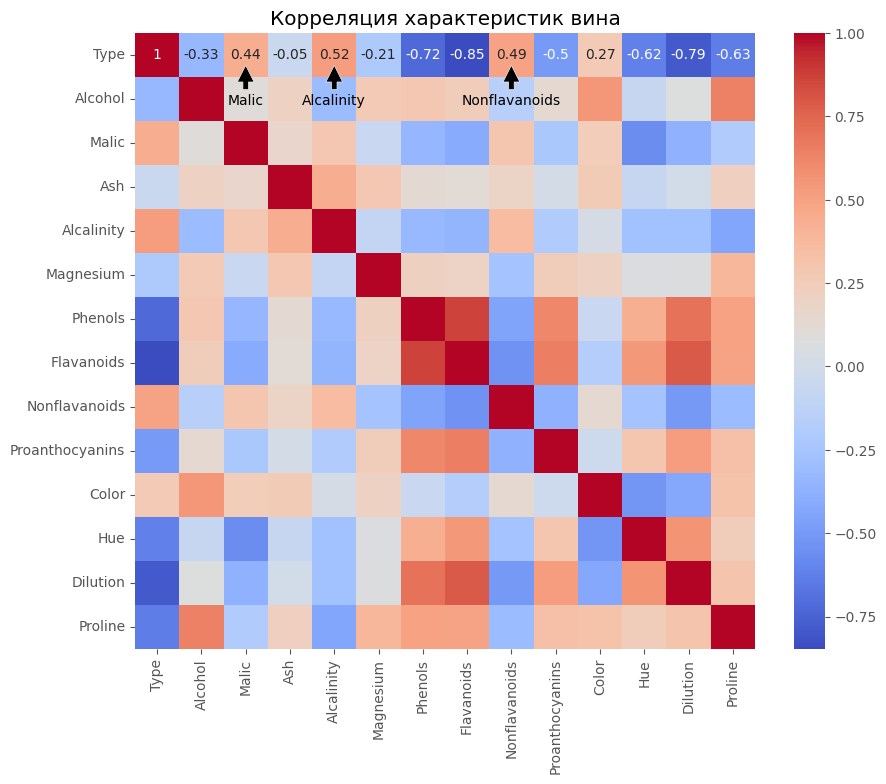

In [7]:
# Находим три переменные с наибольшей корреляцией с 'Type'
top_corr_variables = df.corr()['Type'].sort_values(ascending=False)[1:4].index

# Рисуем график с heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2g", cmap='coolwarm')

# Добавляем стрелки с текстом для топ-3 коррелированных переменных с 'Type'
for i, column in enumerate(df.corr()):
    if column in top_corr_variables:
        plt.annotate(f'{column}', 
                    xy=(i + 0.5, 0.7), 
                    xytext=(i + 0.5, 1.7),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    ha='center', va='bottom')

plt.title('Корреляция характеристик вина')
plt.show()

## Задание 3. Сохранение доли объясненной дисперсии в зависимости от n_components (2 балла)
Воспользуйтесь методом понижения размерности PCA с разным параметром n_components — от 1 до 10. Постройте линейный график совокупной объясненной дисперсии при добавлении каждой новой компоненты.

На том же полотне постройте столбчатую диаграмму: каждый столбец должен показывать, сколько объясненной дисперсии вносит каждая следующая компонента.

In [8]:
X = df.drop('Type', axis=1)
y = df['Type']

pca_dic = {}
for n in range(1, 11):
    n_components = n
    pca = PCA(n_components=n_components, random_state=42)
    X_reduced_pca = pca.fit_transform(X.values)
    pca_dic[n] = pca.explained_variance_ratio_.sum()

pca_df = pd.DataFrame(list(pca_dic.items()), columns=['n_components', 'explained_variance'])
pca_df['explained_variance_diff'] = pca_df['explained_variance'].diff()
pca_df['explained_variance_diff'].fillna(pca_df['explained_variance'], inplace=True)

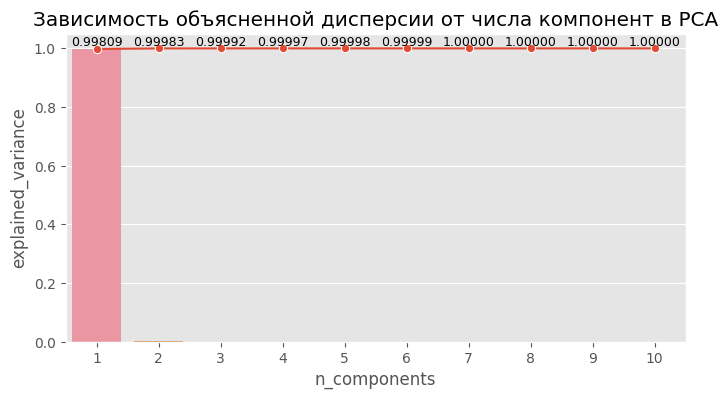

In [9]:
plt.figure(figsize=(8,4))
sns.lineplot(x=pca_df['n_components']-1, y=pca_df['explained_variance'], marker = 'o')
barplot = sns.barplot(x=pca_df['n_components'], y=pca_df['explained_variance_diff'])

for i, value in enumerate(pca_df['explained_variance']):
    barplot.text(i, value - 0.0002, f'{value:.5f}', ha='center', va='bottom', fontsize=9, color='black')

plt.xlabel('n_components')
plt.ylabel('explained_variance')
plt.title('Зависимость объясненной дисперсии от числа компонент в PCA')
plt.show()

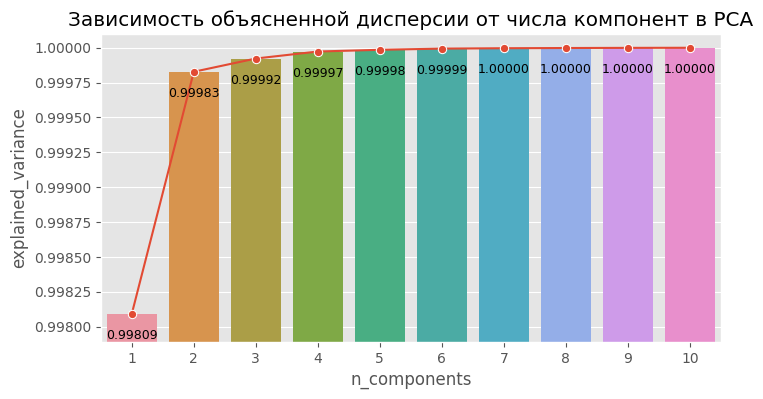

In [10]:
# Предыдущий график кажется неинформативным из-за сильной разницы в размере объясненной дисперсии. Альтернативный график:
plt.figure(figsize=(8,4))
sns.lineplot(x=pca_df['n_components']-1, y=pca_df['explained_variance'], marker = 'o')
barplot = sns.barplot(x=pca_df['n_components'], y=pca_df['explained_variance'])

for i, value in enumerate(pca_df['explained_variance']):
    barplot.text(i, value - 0.0002, f'{value:.5f}', ha='center', va='bottom', fontsize=9, color='black')

plt.xlabel('n_components')
plt.ylabel('explained_variance')
plt.title('Зависимость объясненной дисперсии от числа компонент в PCA')
plt.ylim(pca_dic[1]-0.0002, 1.0001)
plt.show()

## Задание 4. Сравнение результатов работы разных алгоритмов понижения размерности (3 балла)
Воспользуйтесь четырьмя любыми алгоритмами понижения размерности (n_components возьмите равным 2 или 3).

Создайте поле с двумерными или трехмерными графиками, на которых будут отображены результаты работы каждого алгоритма, а цветом будет обозначен тип вина (наша зависимая переменная).

Визуально оцените графики и сделайте вывод о том, какой метод отработал лучше.

Опишите результаты и качественно обоснуйте ваш выбор лучшего алгоритма. Если невозможно выбрать лучший алгоритм, также обоснуйте почему.

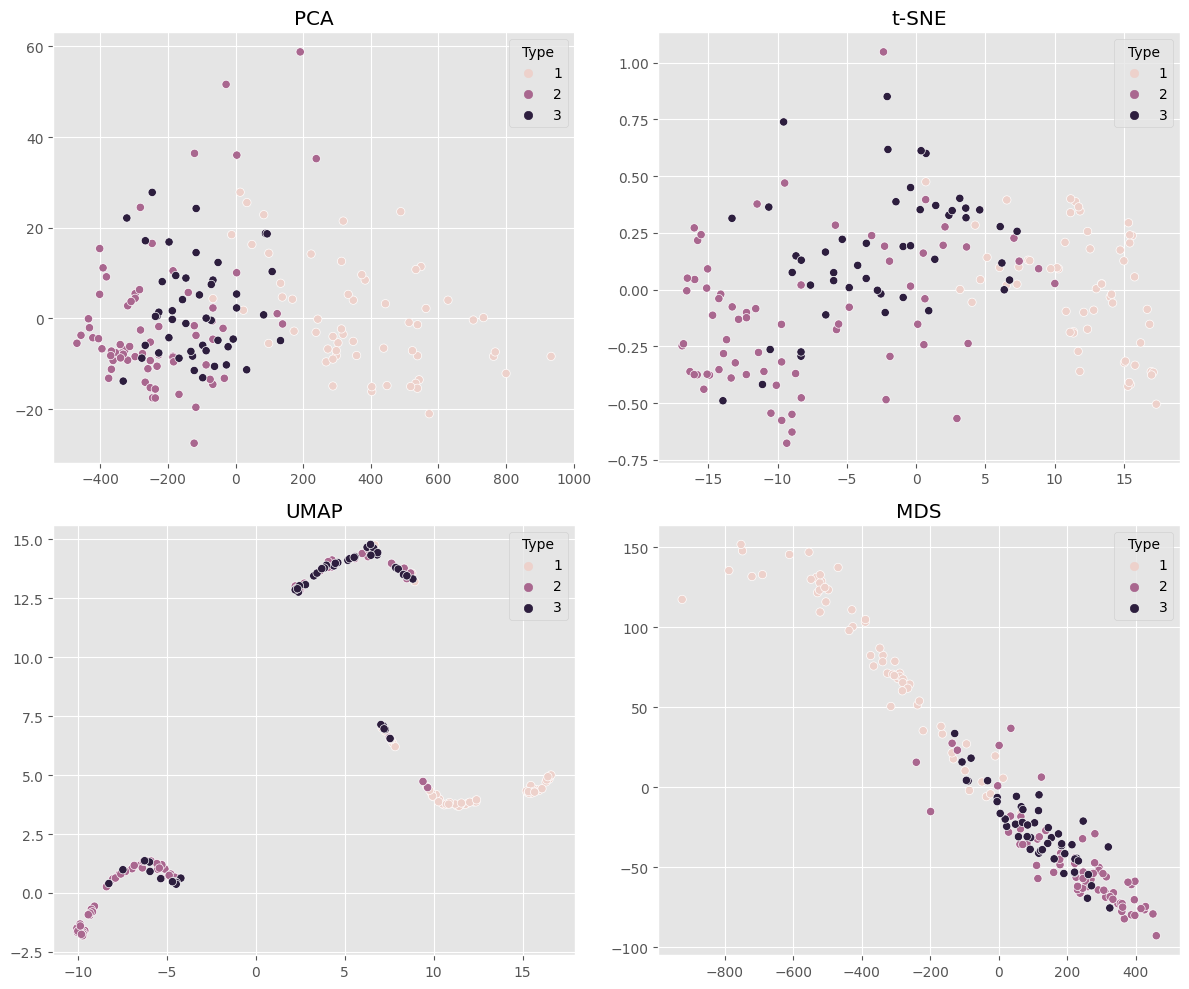

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
n_components=2

# PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(X)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=y, ax=axes[0, 0])
axes[0, 0].set_title('PCA')

# t-SNE
tsne = TSNE(n_components=n_components)
tsne_result = tsne.fit_transform(X)
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=y, ax=axes[0, 1])
axes[0, 1].set_title('t-SNE')

# UMAP
umap = UMAP(n_components=n_components)
umap_result = umap.fit_transform(X)
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=y, ax=axes[1, 0])
axes[1, 0].set_title('UMAP')

# MDS
mds = MDS(n_components=n_components)
mds_result = mds.fit_transform(X)
sns.scatterplot(x=mds_result[:, 0], y=mds_result[:, 1], hue=y, ax=axes[1, 1])
axes[1, 1].set_title('MDS')

plt.tight_layout()
plt.show()


*Все алгоритмы справились довольно посредственно, более-менее удачно всеми выделяется только тип 1, и то не все значения. Возможно проблема кроется в том, что многие признаки имеют высокую прямую или обратную корреляцию.*

## Задание 5. Сравнение результатов работы алгоритмов (4 балла)
Разделите выборку на обучающую и тестовую.

Используйте два метода понижения размерности, которые лучше всего показали себя в предыдущем задании, а также исходные данные без понижения размерности.

Примените 6 любых алгоритмов классификации на этих трех типах данных.

Постройте два sns.heatmap() (для train и test). В каждом из них должно быть по 18 ячеек (6 алгоритмов х 3 вида данных) — в каждой ячейке должно быть указано значение Accuracy для определенного алгоритма с определенными данными. Аналогичную работу мы проделывали на семинаре.

Определите, какой алгоритм дал лучшие результаты и дайте письменное обоснование своего решения:

Как алгоритмы отрабатывают при работе на данных без понижения размерности?
В чем разница в полученных значениях?

In [12]:
X = df.drop('Type', axis=1)
y = df['Type']

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state = 42)

pca=PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

umap=UMAP(n_components=2, random_state=42)
X_train_umap = umap.fit_transform(X_train)
X_test_umap = umap.fit_transform(X_test)

X_train_final = [X_train_pca, X_train_umap, X_train]
X_test_final = [X_test_pca, X_test_umap, X_test]
reductions = ['PCA', 'UMAP', 'full']

In [13]:
seed=42
clf1 = LogisticRegression(random_state=seed)
clf2 = RandomForestClassifier(random_state=seed)
clf3 = KNeighborsClassifier(n_neighbors=5)
clf4 = GaussianNB()
clf5 = LGBMClassifier(random_state=seed, verbosity = -1)
clf6 = CatBoostClassifier(random_state=seed, verbose = 0)

MODELS = [clf1, clf2, clf3, clf4, clf5, clf6]

In [14]:
names = []

reduction_train = {'PCA':[], 'UMAP':[], 'full':[]}
reduction_test = {'PCA':[], 'UMAP':[], 'full':[]}

for model in tqdm(MODELS):
    name = type(model).__name__
    names.append(name)

    for i,(x_train, x_test, reduction) in enumerate(zip(X_train_final, X_test_final, reductions)):
        model.fit(x_train, y_train)
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        accuracy_train = accuracy_score(y_train, y_pred_train)
        reduction_train[reduction].append(accuracy_train)

        accuracy_test = accuracy_score(y_test, y_pred_test)
        reduction_test[reduction].append(accuracy_test)

    print(f'* {name} finished.')

  0%|          | 0/6 [00:00<?, ?it/s]

* LogisticRegression finished.
* RandomForestClassifier finished.
* KNeighborsClassifier finished.
* GaussianNB finished.
* LGBMClassifier finished.
* CatBoostClassifier finished.


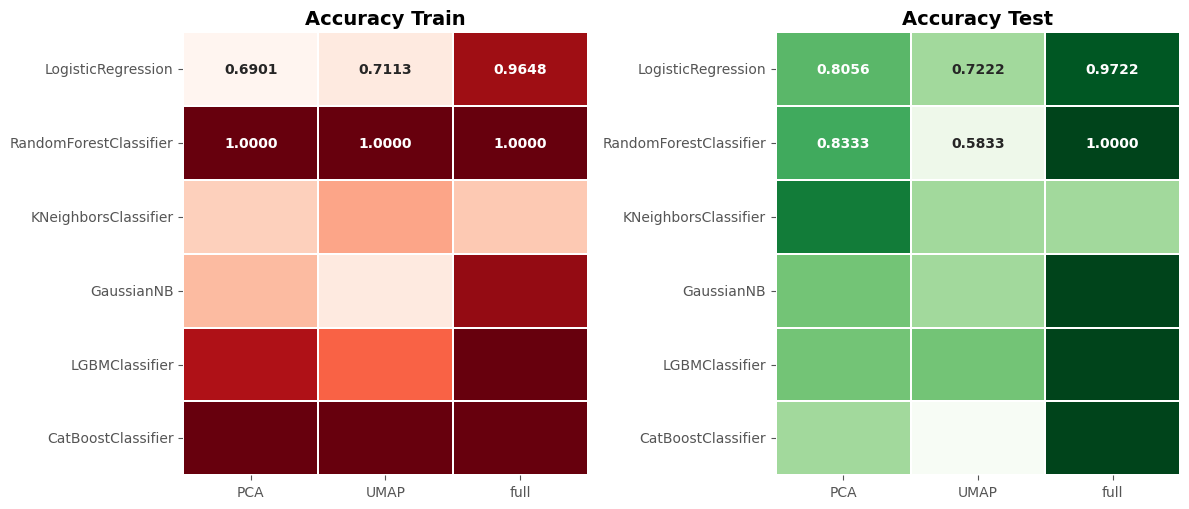

In [15]:
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5.2))
axs = axs.flat

sns.heatmap(pd.DataFrame(index = names, data = reduction_train),
            cmap = 'Reds',
            annot = True,
            annot_kws = {'fontweight':'bold'},
            fmt = '.4f',
            linewidths = 1.1,
            square = False,
            cbar = False,
            ax = axs[0])
sns.heatmap(pd.DataFrame(index = names, data = reduction_test),
            cmap = 'Greens',
            annot = True,
            annot_kws = {'fontweight':'bold'},
            fmt = '.4f',
            linewidths = 1.1,
            square = False,
            cbar = False,
            ax = axs[1])
axs[0].set_title("Accuracy Train", fontsize = 14, fontweight = 'bold', color = 'black')
axs[1].set_title("Accuracy Test", fontsize = 14, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

*В данном примере все методы классификации отработали лучше без понижения размерности, кроме KNN, который показал улучшение результата при понижении размерности с помощью PCA (возможно, помогло уменьшение шума).*

## Задание 6. Более пристальный анализ (2 балла)
Для лучшего алгоритма из предыдущего задания постройте Classification Report, Confusion Matrix, Precision Recall Curve, ROC Curve.

Удалось ли обнаружить какие-то аномалии в работе нашего алгоритма? Можем ли мы принять полученные результаты?

In [16]:
# Построим графики для KNeighborsClassifier

clf3 = KNeighborsClassifier(n_neighbors=5)
clf3.fit(X_train_pca, y_train)
y_pred_train = clf3.predict(X_train_pca)
y_pred_test = clf3.predict(X_test_pca)

In [17]:
# Classification Report
print("Classification Report on Train Data:")
print(classification_report(y_train, y_pred_train))
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

Classification Report on Train Data:
              precision    recall  f1-score   support

           1       0.82      0.93      0.87        45
           2       0.76      0.65      0.70        57
           3       0.64      0.68      0.66        40

    accuracy                           0.75       142
   macro avg       0.74      0.75      0.74       142
weighted avg       0.75      0.75      0.74       142

Classification Report on Test Data:
              precision    recall  f1-score   support

           1       0.93      1.00      0.97        14
           2       0.88      1.00      0.93        14
           3       1.00      0.62      0.77         8

    accuracy                           0.92        36
   macro avg       0.94      0.88      0.89        36
weighted avg       0.93      0.92      0.91        36



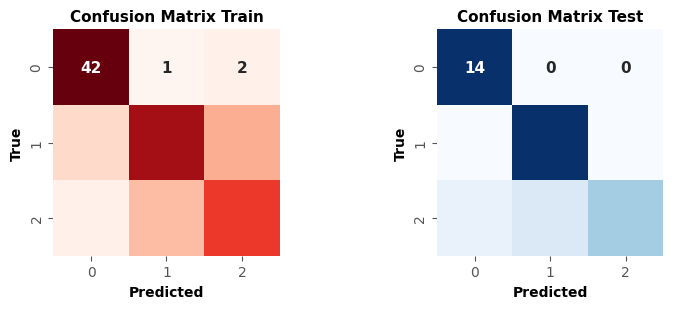

In [18]:
cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,3.2))
axs = axs.flat

sns.heatmap(cf_mx_train, cmap = 'Reds', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', cbar = False, square = True, ax = axs[0])
sns.heatmap(cf_mx_test, cmap = 'Blues', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', cbar = False, square = True, ax = axs[1])
axs[0].set_xlabel('Predicted', fontsize = 10, fontweight = "bold", color = "black")
axs[1].set_xlabel('Predicted', fontsize = 10, fontweight = "bold", color = "black")
axs[0].set_ylabel('True', fontsize = 10, fontweight = "bold", color = "black")
axs[1].set_ylabel('True', fontsize = 10, fontweight = "bold", color = "black")
axs[0].set_title('Confusion Matrix Train', fontsize = 11, fontweight = "bold", color = "black")
axs[1].set_title('Confusion Matrix Test', fontsize = 11, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

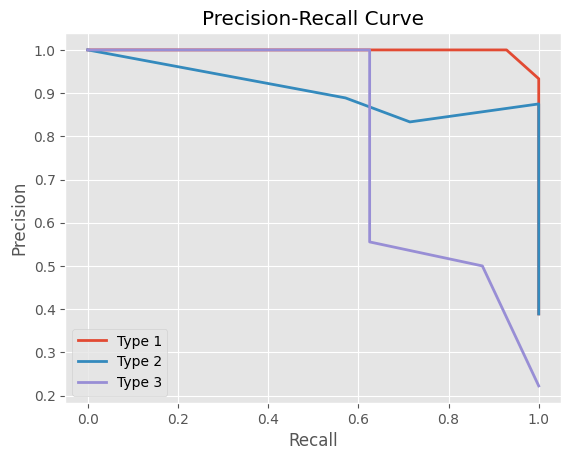

In [19]:
# Precision-Recall Curve
precision = dict()
recall = dict()
thresholds = dict()

y_test_binarized = label_binarize(y_test, classes=list(set(y_test)))
type_list = sorted(list(set(y_test)))

for i in range(len(type_list)):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binarized[:, i], clf3.predict_proba(X_test_pca)[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Type {type_list[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

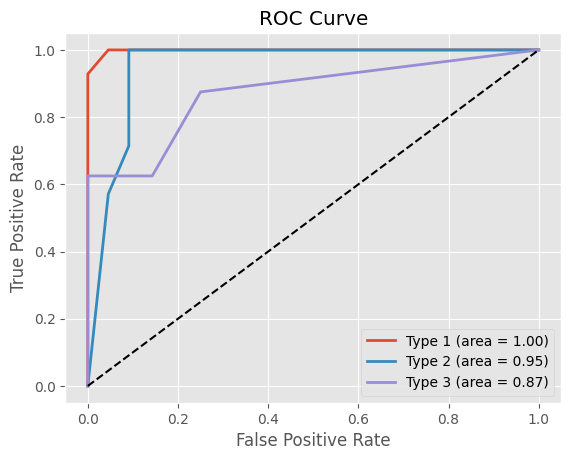

In [20]:
# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(len(type_list)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], clf3.predict_proba(X_test_pca)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Type {type_list[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0,1], linestyle = '--', color = 'black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

*Проблему похожести 2 и 3 класса модель не смогла решить до конца, тем не менее показатели достаточно высокие. Чтобы улучшить результаты стоит попробовать исключить признаки с высокой корелляцией, после этого можно попробовать подобрать более подходящие гиперпараметры. Также можно попробовать использовать нейронную сеть для улавливания скрытых связей между признаками.* 